<a href="https://colab.research.google.com/github/rahiakela/deep-learning-with-python-francois-chollet/blob/5-deep-learning-for-computer-vision/2_training_convnet_from_scratch_on_small_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training convnet from scratch on a small dataset

Having to train an image-classification model using very little data is a common situation, which you’ll likely encounter in practice if you ever do computer vision in a professional context. 

A “few” samples can mean anywhere from a few hundred to a
few tens of thousands of images. As a practical example, we’ll focus on classifying images as dogs or cats, in a dataset containing 4,000 pictures of cats and dogs (2,000 cats, 2,000 dogs). We’ll use 2,000 pictures for training—1,000 for validation, and 1,000 for testing.

We’ll review one basic strategy to tackle this problem: **training a new model from scratch using what little data you have**. You’ll start by naively training a small convnet on the 2,000 training samples, without any regularization, to set a baseline for what can be achieved. 

This will get you to a classification accuracy of 71%. At
that point, the main issue will be overfitting. Then we’ll introduce data augmentation, a powerful technique for mitigating overfitting in computer vision. By using data augmentation you’ll improve the network to reach an accuracy of 82%.

We’ll review two more essential techniques for applying deep
learning to small datasets: 
* **feature extraction with a pretrained network** (which will get you to an accuracy of 90% to 96%) 
* and **fine-tuning a pretrained network** (this will get you to a final accuracy of 97%). 

Together, these three strategies—training a small model from scratch, doing feature extraction using a pretrained model, and fine-tuning a pretrained model—will constitute your future toolbox for tackling the problem of performing image classification with small datasets.

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

TensorFlow 2.x selected.


## The relevance of deep learning for small-data problems

You’ll sometimes hear that deep learning only works when lots of data is available. This is valid in part: one fundamental characteristic of deep learning is that it can find interesting features in the training data on its own, without any need for manual feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where the input samples are very highdimensional, like images.



## Downloading the data

The Dogs vs. Cats dataset that you’ll use isn’t packaged with Keras. It was made available by Kaggle as part of a computer-vision competition in late 2013, back when convnets weren’t mainstream. You can download the original dataset from [www.kaggle.com/c/dogs-vs-cats/data](https://www.kaggle.com/c/dogs-vs-cats/data).

<img src='https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg?raw=1' width='800'/>

Unsurprisingly, the dogs-versus-cats Kaggle competition in 2013 was won by entrants who used convnets. The best entries achieved up to 95% accuracy. In this example, you’ll get fairly close to this accuracy (in the next section), even though you’ll train
your models on less than 10% of the data that was available to the competitors.

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed). After downloading and uncompressing it, you’ll create a new dataset containing three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 500 samples of each class.

Let's donload datasets from Kaggle.

In [2]:
# reference: https://medium.com/@saedhussain/google-colaboratory-and-kaggle-datasets-b57a83eb6ef8
# Install Kaggle library
! pip install -q kaggle

     |████████████████████████████████| 122kB 2.8MB/s 
ERROR: tensor2tensor 1.14.1 has requirement tensorflow-probability==0.7.0, but you'll have tensorflow-probability 0.9.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.7.2, but you'll have google-auth 1.11.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [3]:
# Try to downlaod data for the dogs-vs-cats challenge, it will fail.
!kaggle competitions download -c dogs-vs-cats

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [0]:
# copy kaggle.json file to .kaggle directory
! cp kaggle.json ~/.kaggle/

In [5]:
# Now try to downlaod data for the dogs-vs-cats challenge, it will succeed
!kaggle competitions download -c dogs-vs-cats

 98% 533M/543M [00:08<00:00, 57.8MB/s]
100% 543M/543M [00:08<00:00, 67.1MB/s]
 97% 264M/271M [00:05<00:00, 70.6MB/s]
100% 271M/271M [00:05<00:00, 47.8MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 31.4MB/s]


### Copying images to training, validation, and test directories

In [0]:
import os, shutil
import zipfile

In [0]:
# path to the directory where the original dataset was uncompressed
original_dataset_dir = 'kaggle_original_data'
# directory where we will store our smaller dataset
base_dir = 'cats_and_dogs_small'

# remove directories if it already exists
shutil.rmtree(original_dataset_dir, ignore_errors=True)
shutil.rmtree(base_dir, ignore_errors=True)

# create directories
os.mkdir(original_dataset_dir)
os.mkdir(base_dir)

In [0]:
# unzip train dataset
with zipfile.ZipFile("train.zip","r") as zip_ref:
    zip_ref.extractall(original_dataset_dir)

# unzip test dataset
with zipfile.ZipFile("test1.zip","r") as zip_ref:
    zip_ref.extractall(original_dataset_dir)

In [0]:
# create directories for our training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# create directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# create directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# create directory with our test cat/dog pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir + '/train/', fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir + '/train/', fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir + '/train/', fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir + '/train/', fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir + '/train/', fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir + '/train/', fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [10]:
print(f'total training cat images: {len(os.listdir(train_cats_dir))}')
print(f'total training dog  images: {len(os.listdir(train_dogs_dir))}')
print(f'total validation  cat images: {len(os.listdir(validation_cats_dir))}')
print(f'total validation  dog images: {len(os.listdir(validation_dogs_dir))}')
print(f'total test cat images: {len(os.listdir(test_cats_dir))}')
print(f'total test dog images: {len(os.listdir(test_dogs_dir))}')

total training cat images: 1000
total training dog  images: 1000
total validation  cat images: 500
total validation  dog images: 500
total test cat images: 500
total test dog images: 500


So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate measure of success.

## Building our network

We've already built a small convnet for MNIST in the previous example, so you should be familiar with them. We will reuse the same general structure: our convnet will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one more Conv2D + MaxPooling2D stage. This serves both to augment the capacity of the network, and to further reduce the size of the feature maps, so that they aren't overly large when we reach the Flatten layer. Here, since we start from inputs of size 150x150 (a somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the Flatten layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a Dense layer of size 1) and a sigmoid activation. This unit will encode the probability that the network is looking at one class or the other.

In [0]:
model = keras.models.Sequential()

# Conv2D + MaxPooling2D layer
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(keras.layers.Flatten())

# Dense layer
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

For our compilation step, we'll go with the RMSprop optimizer as usual. Since we ended our network with a single sigmoid unit, we will use binary crossentropy as our loss.

In [0]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image processing helper tools, located at keras.preprocessing.image. 

In particular, it contains the class ImageDataGenerator which allows to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we will use here.

### Using ImageDataGenerator to read images from directories

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_dir, # target directory
                                                    target_size=(150, 150), # resized to 150x150
                                                    batch_size=20,
                                                    # Since we use binary_crossentropy loss, we need binary labels
                                                    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape (20, 150, 150, 3)) and binary labels (shape (20,)). 20 is the number of samples in each batch (the batch size). 

Note that the generator yields these batches indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to break the iteration loop at some point.

In [0]:
for data_batch, labels_batch in train_generator:
  print(f'data batch shape: {data_batch.shape}')
  print(f'labels batch shape: {labels_batch.shape}')
  break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


### Fitting the model using a batch generator

Let's fit our model to the data using the generator. We do it using the fit_generator method, the equivalent of fit for data generators like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before declaring an epoch over. 

This is the role of the steps_per_epoch argument: after having drawn steps_per_epoch batches from the generator, i.e. after having run for steps_per_epoch gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using fit_generator, one may pass a validation_data argument, much like with the fit method. Importantly, this argument is allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. 

If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly, and thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/30
100/100 [==============================] - 17s 166ms/step - loss: 0.6883 - accuracy: 0.5570 - val_loss: 0.6742 - val_accuracy: 0.5910
Epoch 2/30
100/100 [==============================] - 9s 87ms/step - loss: 0.6578 - accuracy: 0.6115 - val_loss: 0.6454 - val_accuracy: 0.6250
Epoch 3/30
100/100 [==============================] - 9s 87ms/step - loss: 0.6202 - accuracy: 0.6575 - val_loss: 0.6159 - val_accuracy: 0.6570
Epoch 4/30
100/100 [==============================] - 9s 87ms/step - loss: 0.5803 - accuracy: 0.6870 - val_loss: 0.6068 - val_accuracy: 0.6700
Epoch 5/30
100/100 [==============================] - 9s 86ms/step - loss: 0.5491 - accuracy: 0.7105 - val_loss: 0.6650 - val_accuracy: 0.6290
Epoch 6/30
100/100 [==============================] - 9s 85ms/step - loss: 0.5179 - accuracy: 0.7465 - val_loss: 0

It’s good practice to always save your models after training.

In [0]:
model.save('cats_and_dogs_small_1.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

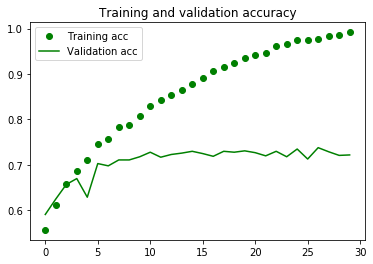

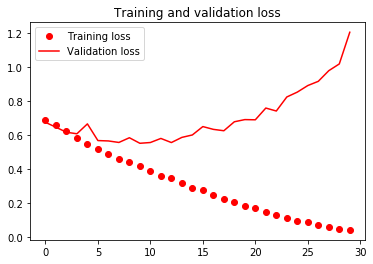

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: data augmentation.

## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. 

Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better.

### Setting up a data augmentation configuration via ImageDataGenerator

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our ImageDataGenerator instance. Let's get started with an example:

In [0]:
datagen = ImageDataGenerator(rotation_range=40, 
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures.
* width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* shear_range is for randomly applying shearing transformations.
* zoom_range is for randomly zooming inside pictures.
* horizontal_flip is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

### Displaying some randomly augmented training images

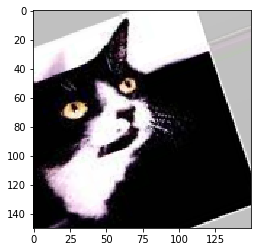

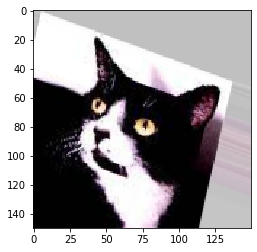

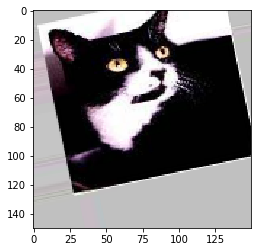

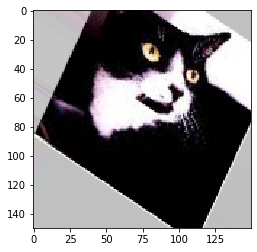

In [13]:
from tensorflow.keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1, ) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 4 == 0:
    break
  
plt.show()

### Defining a new convnet that includes dropout

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. 

To further fight overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [14]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### Training the convnet using data-augmentation generators

Let's train our network using data augmentation and dropout:

In [15]:
# https://stackoverflow.com/questions/55141076/how-to-apply-data-augmentation-in-tensorflow-2-0-after-tfds-load
# https://stackoverflow.com/questions/55421290/tensorflow-2-0-keras-how-to-write-image-summaries-for-tensorboard/55754700#55754700
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_dir,  # target directory
                                                    target_size=(150, 150), # resized to 150x150
                                                    batch_size=32,
                                                    # Since we use binary_crossentropy loss, we need binary labels
                                                    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir,  # target directory
                                                    target_size=(150, 150), # resized to 150x150
                                                    batch_size=32,
                                                    class_mode='binary')

# train the model
history = model.fit_generator(train_generator,
                              steps_per_epoch=2000,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=800)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2000 steps, validate for 800 steps
Epoch 1/50
  63/2000 [..............................] - ETA: 55:51 - loss: 0.7105 - accuracy: 0.5140

Let's save our model -- we will be using it in the section on convnet visualization.

In [0]:
model.save('cats_and_dogs_small_2.h5')

Let's plot our results again:

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next two sections.